- Insert branded content
- Separate content by category (location, resi, commercial)
- Track Subs
- Break data out by time series

## Global Stuff

In [ ]:
SITE_ID    = "therealdeal.com"
API_SECRET = "SECRET"

In [2]:
SITE_ID    = "therealdeal.com"
API_SECRET = "Z5evAX56zI2htaKNk36665zSaJEcIGYiCZjeI7jpUzI"

## Grab Geographic Sections

In [14]:
import requests

SECS_URL = "https://api.parsely.com/v2/analytics/sections"

now = datetime.utcnow()
params = {
    "apikey":       SITE_ID,
    "secret":       API_SECRET,
    "period_start": (now - timedelta(days=30)).isoformat(),
    "period_end":   now.isoformat(),
    "limit":        1000,
    "page":         1
}

r = requests.get(SECS_URL, params=params)
r.raise_for_status()
sections_data = r.json().get("data", [])

# Extract exactly the strings you need:
available_slugs = [ rec["section"] for rec in sections_data ]
print("Available section slugs:", available_slugs)

Available section slugs: ['New York', 'South Florida', 'National', 'Los Angeles', 'Chicago', 'San Francisco', 'Tri-State', 'Dallas', 'Texas', 'Houston', 'Austin', 'Nashville', 'Seattle', 'Boston', 'Uncategorized', 'Atlanta', 'Washington D.C.', 'Phoenix', 'Fort Worth', 'Denver', 'Philadelphia', 'San Antonio', 'Las Vegas', 'Charlotte', 'Tampa', 'Orlando']


## Get Post data by section, group by author and sum page views

In [21]:
df.tags

0        [New York, Residential, parsely_smart:entity:L...
1        [Affordable Housing, Eric Adams, Housing Polic...
2        [Development, New York, parsely_smart:entity:R...
3        [Blackstone, CBRE, Commercial Real Estate, New...
4        [Boruch Drillman, Commercial, Crime, Fannie Ma...
                               ...                        
16637    [Development, Hotel, National, Orlando, The Me...
16638    [Apartments, National, Orlando, RentCafe, Rent...
16639    [Apartments, Development, Emerson Internationa...
16640    [Home Prices, National, Orlando, Orlando Regio...
16641    [Apartments, Aventon Companies, Commercial Rea...
Name: tags, Length: 16642, dtype: object

In [15]:
import pandas as pd
from datetime import datetime, timedelta


POSTS_URL = "https://api.parsely.com/v2/analytics/posts"

# 30-day ISO window (no microseconds, add Z if you need UTC)
now          = datetime.utcnow().replace(microsecond=0)
period_end   = now.isoformat() + "Z"
period_start = (now - timedelta(days=30)).isoformat() + "Z"

# slugs (no brackets, no quotes)
sections = available_slugs

# ── Fetch posts per section ────────────────────────────────────────────────
all_posts = []
for section in sections:
    resp = requests.get(
        POSTS_URL,
        params={
            "apikey":       SITE_ID,
            "secret":       API_SECRET,
            "section":      section,         # plain slug
            "period_start": period_start,
            "period_end":   period_end,
            "limit":        2000,            # max you can get in one go
            "sort":         "views"
        }
    )
    resp.raise_for_status()
    data = resp.json().get("data", [])
    if not data:
        print(f"No posts returned for section={section}. Check slug or date range.")
        continue

    # tag so we know which section each post came from
    for post in data:
        post["section"] = section

    all_posts.extend(data)

# ── Roll up to per-author, per-section ──────────────────────────────────────
df = pd.json_normalize(all_posts)

# flatten out the nested views metric
df["views"] = df["metrics.views"]

# group
df_auth_sec = (
    df
    .groupby(["author","section"], dropna=False)
    .agg(pageviews=("views","sum"))
    .reset_index()
)

print(df_auth_sec.head())

            author        section  pageviews
0  Abigail Nehring    Los Angeles       3546
1  Abigail Nehring  San Francisco       1458
2     Adam Farence       National          2
3     Adam Farence  San Francisco         11
4     Adam Farence  South Florida       1230


In [37]:
df_auth_sec = df_auth_sec.sort_values(by="pageviews",ascending=False)
df_auth_sec.author.unique()

array(['Katherine Kallergis', 'Brand Studio', 'Francisco Alvarado',
       'TRD Staff', 'Kate Hinsche', 'Elizabeth Cryan', 'Keith Larsen',
       'Kari Hamanaka', 'Rich Bockmann', 'Sheridan Wall', 'Jake Indursky',
       'Sam Lounsberry', 'Emily Landes', 'Lidia Dinkova', 'Kelli Duncan',
       'Emma Whalen', 'Suzannah Cavanaugh', 'Jess Hardin', 'Alena Botros',
       'Harrison Connery', 'Kathryn Brenzel', 'Mary Diduch',
       'Holden Walter-Warner', 'Lilah Burke', 'Mike Romano',
       'Jordan Pandy', 'Isabella Farr', 'Isaiah Mitchell',
       'Ellen Cranley', 'Andrew Asch', 'Erik Engquist',
       'Lauren Elkies Schram', 'Abigail Nehring', 'Adam Farence',
       'Miranda Davis', 'Amanda Rabines', 'Master Brokers Forum',
       'Judah Duke', 'Lois Weiss', 'Christian Bautista', 'Orion Jones',
       'Chris Malone Méndez', 'Erin Hudson', 'E.B. Solomont',
       'Daria Solovieva', 'Rachel Herzog', 'Sasha Jones', 'Brandon Sams',
       'Matthew Niksa', 'Mark Maurer', 'Pat Ralph', 'Cale We

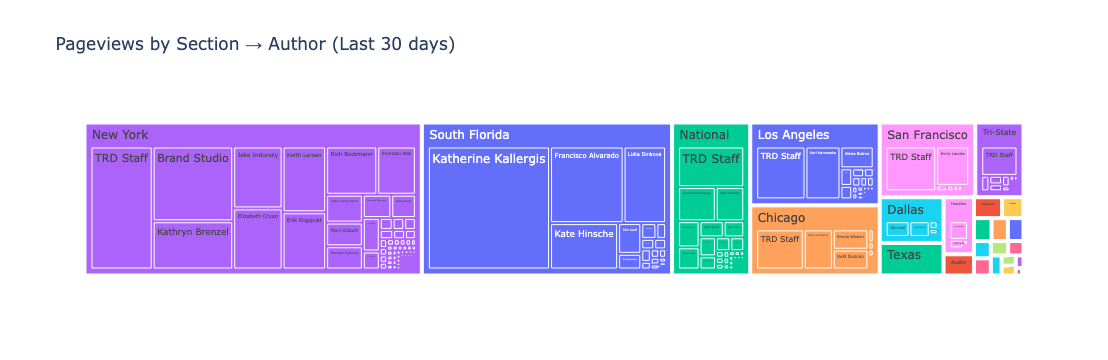

In [17]:
import plotly.express as px

fig = px.treemap(
    df_auth_sec,
    path=["section","author"],   # hierarchy
    values="pageviews",          # size by pageviews
    color="section",             # color by section
    hover_data=["pageviews"],    # show pageviews on hover
    title="Pageviews by Section → Author (Last 30 days)"
)
fig.write_html("index.html")
fig.show()

In [19]:
df.tags

0        [New York, Residential, parsely_smart:entity:L...
1        [Affordable Housing, Eric Adams, Housing Polic...
2        [Development, New York, parsely_smart:entity:R...
3        [Blackstone, CBRE, Commercial Real Estate, New...
4        [Boruch Drillman, Commercial, Crime, Fannie Ma...
                               ...                        
16637    [Development, Hotel, National, Orlando, The Me...
16638    [Apartments, National, Orlando, RentCafe, Rent...
16639    [Apartments, Development, Emerson Internationa...
16640    [Home Prices, National, Orlando, Orlando Regio...
16641    [Apartments, Aventon Companies, Commercial Rea...
Name: tags, Length: 16642, dtype: object

## Get Tags

In [24]:
# — after you build df via pd.json_normalize(all_posts) …

# 1) See exactly which tags you’ve got
all_tags = pd.Series(df['tags'].explode()).dropna().unique()
print("Distinct tags in your 30-day window:\n", sorted(all_tags))

Distinct tags in your 30-day window:
 ['1 Indian Chase Drive', '1 Park Row Development', '1000 Pine Street', '1051 and 1101 Sandisk Drive', '1088 Sansome Street LLC', '11 East Partners', '110 N. Carpenter St', '1140 Avalon Blvd LLC', '1144 South Second Street', '115 Sansome', '1155 North Coleman Avenue', '1220 West Jackson Boulevard', '1290 Sixth Avenue', '130 Townsend Property Owner', '13th Floor Investments', '1411 South Michigan Ave.', '15 Central Park West', '1515 E. Woodfield Road', '152 North Third Street Owner', '15480 and 15500 Los Gatos Blvd. Whole Foods', '15600 and 15650 Los Gatos Boulevard', '160 Mountain Wood Lane', '160 North Buckley Road', '1601 Vine Street', '161 Maiden Lane', '17100 Laguna Canyon Road', '180 Broome Street', '181 Sanchez Street', '1844 Market CA LLC', '1907 Capital', '2 Gateway', '200 Folsom Street', '200 West Monroe', '2017 In Review', '2019 In Review', '202 Broome Street', '2020 In Review', '2021 In Review', '2022 In Review', '2023 in Review', '2023 y

In [26]:
df

,_hits,author,authors,full_content_word_count,image_url,link,metadata,pub_date,section,tags,thumb_url_medium,title,url,metrics.recirculation_rate,metrics.views,views,classification
0,98643,Brand Studio,[Brand Studio],941,https://static.therealdeal.com/wp-content/uplo...,https://therealdeal.com/sponsored/flatiron-rea...,,2025-05-23T19:01:00,New York,"[New York, Residential, parsely_smart:entity:L...",https://images.parsely.com/WPqMoH0yGKhiiEERlHy...,"As Housing Demand Skyrockets, Investors Turn t...",https://therealdeal.com/sponsored/flatiron-rea...,0.003791,98643,98643,Residential
4,9433,Kathryn Brenzel,[Kathryn Brenzel],1471,https://static.therealdeal.com/wp-content/uplo...,https://therealdeal.com/new-york/2025/06/16/wh...,,2025-06-16T20:34:58,New York,"[Boruch Drillman, Commercial, Crime, Fannie Ma...",https://images.parsely.com/TCWMh92yrzzBjHl0aoT...,No prison for Boruch Drillman in mortgage frau...,https://therealdeal.com/new-york/2025/06/16/wh...,0.207993,9433,9433,Commercial
6,8634,Elizabeth Cryan,[Elizabeth Cryan],478,https://static.therealdeal.com/wp-content/uplo...,https://therealdeal.com/new-york/2025/06/16/ga...,,2025-06-16T12:00:00,New York,"[Commercial, Extell Development, Gary Barnett,...",https://images.parsely.com/3oIy-lAYBnhTpj2Kzbe...,Gary Barnett reveals plans for Upper West Side...,https://therealdeal.com/new-york/2025/06/16/ga...,0.248552,8634,8634,Commercial
8,8254,Jake Indursky,[Jake Indursky],557,https://static.therealdeal.com/wp-content/uplo...,https://therealdeal.com/new-york/2025/06/04/li...,,2025-06-04T19:30:00,New York,"[Brown Harris Stevens, Luxury Real Estate, New...",https://images.parsely.com/nR_U65MrZTzGTUh7Dnp...,Sackler heir buys $11M Brooklyn Heights townhouse,https://therealdeal.com/new-york/2025/06/04/li...,0.181609,8254,8254,Residential
9,7828,Elizabeth Cryan,[Elizabeth Cryan],332,https://static.therealdeal.com/wp-content/uplo...,https://therealdeal.com/new-york/2025/06/23/to...,,2025-06-23T15:29:40,New York,"[Brandon Miller, Commercial, New York, Real Es...",https://images.parsely.com/ZbyZHUIiv4vS6SirFUe...,Toll Brothers in contract to buy Brandon Mille...,https://therealdeal.com/new-york/2025/06/23/to...,0.134645,7828,7828,Commercial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,6,TRD Staff,[TRD Staff],300,https://static.therealdeal.com/wp-content/uplo...,https://therealdeal.com/national/orlando/2024/...,,2024-04-02T20:00:00,Orlando,"[John Pinel, Luxury Real Estate, Mansion, Mick...",https://images.parsely.com/9PWMVNOnPPVXnjgG9iw...,Winter Park mansion sells for $9.7M,https://therealdeal.com/national/orlando/2024/...,0.000000,6,6,Residential
16633,6,TRD Staff,[TRD Staff],286,https://static.therealdeal.com/wp-content/uplo...,https://therealdeal.com/national/orlando/2024/...,,2024-01-17T20:09:56,Orlando,"[Condos, Hurricane Ian, Lawsuit, National, Orl...",https://images.parsely.com/I6VXeXbMUuZJQxy43UB...,Orlando condo board sues contractor over $27M ...,https://therealdeal.com/national/orlando/2024/...,0.166667,6,6,Residential
16634,5,TRD Staff,[TRD Staff],322,https://static.therealdeal.com/wp-content/uplo...,https://therealdeal.com/national/orlando/2024/...,,2024-03-06T22:51:46,Orlando,"[Barclay Group, Commercial, Construction Loans...",https://images.parsely.com/TruKsZ6-t0W8pkYDbNf...,Barclay scores $30M loan for Brevard County re...,https://therealdeal.com/national/orlando/2024/...,0.000000,5,5,Commercial
16638,1,TRD Staff,[TRD Staff],268,https://static.therealdeal.com/wp-content/uplo...,https://therealdeal.com/national/orlando/2024/...,,2024-02-13T21:22:56,Orlando,"[Apartments, National, Orlando, RentCafe, Rent...",https://images.parsely.com/zQ-woeCeIIgNmUFP3Y_...,Orlando is Florida’s most-popular rental city,https://therealdeal.com/national/orlando/2024/...,0.000000,1,1,Residential


## Make data viz with tags

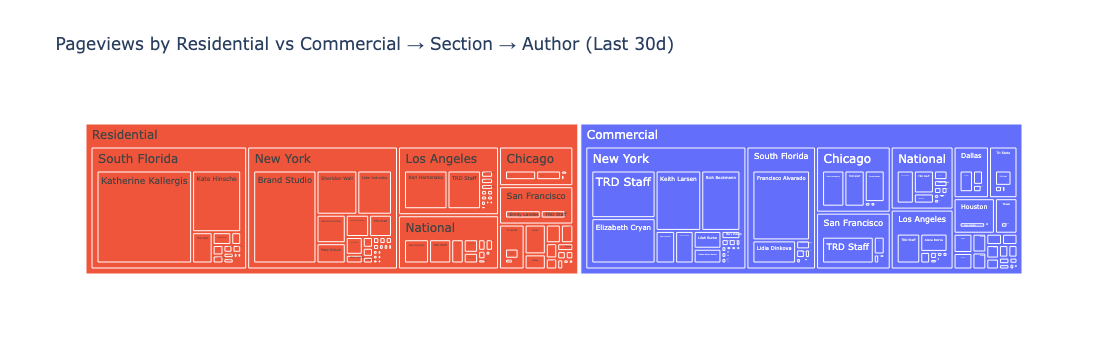

In [36]:
# 2) Classify based on presence in that list
def classify(tags):
    # normalize to lowercase for safe matching
    tags_lower = [t.lower() for t in tags]
    if 'residential' in tags_lower:
        return 'Residential'
    if 'commercial' in tags_lower:
        return 'Commercial'
    return None

df['classification'] = df['tags'].apply(classify)

# Optional: drop everything that wasn’t explicitly tagged
df = df[df['classification'].notnull()]

# 3) Roll up to classification → section → author
df_auth_sec = (
    df
    .groupby(['classification','section','author'], dropna=False)
    .agg(pageviews=('metrics.views','sum'))
    .reset_index()
    .sort_values('pageviews', ascending=False)
)

# 4) Treemap (same as before)
import plotly.express as px
fig = px.treemap(
    df_auth_sec,
    path=['classification','section','author'],
    values='pageviews',
    color='classification',
    hover_data=['pageviews'],
    title='Pageviews by Residential vs Commercial → Section → Author (Last 30d)'
)
fig.show()
fig.write_html('resi_comm.html')


## Get subscriptions

No conversion data returned; creating empty subscription frame.


/var/folders/rq/0_j_rksd7psgdycg9c1qwf6m0000gp/T/ipykernel_93962/1725599553.py:119: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



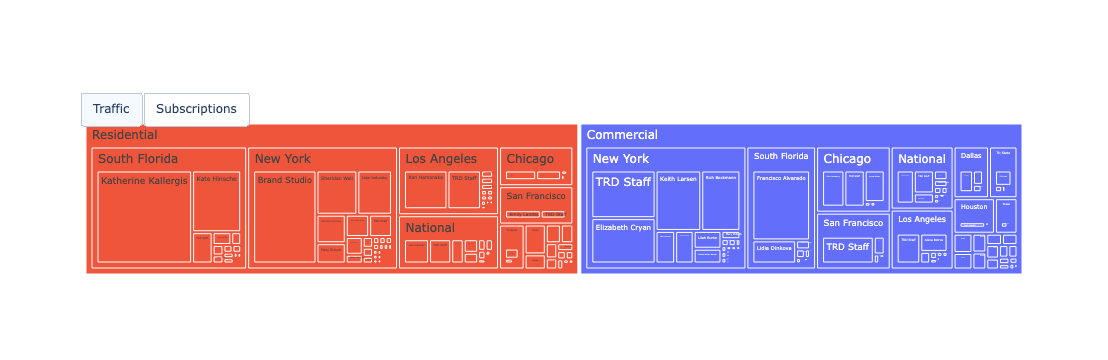

In [34]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go

# 30-day ISO window (no microseconds)
now = datetime.utcnow().replace(microsecond=0)
period_end = now.isoformat() + "Z"
period_start = (now - timedelta(days=30)).isoformat() + "Z"

# ─── 1) PULL SECTION SLUGS ────────────────────────────────────────────────────
SECS_URL = "https://api.parsely.com/v2/analytics/sections"
secs_params = {
    "apikey":       SITE_ID,
    "secret":       API_SECRET,
    "period_start": period_start,
    "period_end":   period_end,
    "limit":        1000,
    "page":         1
}
r = requests.get(SECS_URL, params=secs_params)
r.raise_for_status()
sections = [rec["section"] for rec in r.json().get("data", [])]

# ─── 2) PULL POSTS ────────────────────────────────────────────────────────────
POSTS_URL = "https://api.parsely.com/v2/analytics/posts"
all_posts = []
for section in sections:
    resp = requests.get(
        POSTS_URL,
        params={
            "apikey":       SITE_ID,
            "secret":       API_SECRET,
            "section":      section,
            "period_start": period_start,
            "period_end":   period_end,
            "limit":        2000,
            "sort":         "views"
        }
    )
    resp.raise_for_status()
    data = resp.json().get("data", [])
    if not data:
        continue
    for post in data:
        post["section"] = section
    all_posts.extend(data)

# ─── 3) BUILD POSTS DATAFRAME ─────────────────────────────────────────────────
df = pd.json_normalize(all_posts)
if "url" not in df.columns and "canonical_url" in df.columns:
    df.rename(columns={"canonical_url": "url"}, inplace=True)
df["views"] = df.get("metrics.views", 0)

# ─── 4) CLASSIFY BY TAGS ──────────────────────────────────────────────────────
def classify(tags):
    tags_lower = [t.lower() for t in (tags or [])]
    if "residential" in tags_lower:
        return "Residential"
    if "commercial" in tags_lower:
        return "Commercial"
    return None

df["classification"] = df["tags"].apply(classify)
df = df[df["classification"].notnull()]

# ─── 5) PULL SUBSCRIPTION CONVERSIONS ─────────────────────────────────────────
CONV_URL = "https://api.parsely.com/v2/conversions/url"
conv_params = {
    "apikey":           SITE_ID,
    "secret":           API_SECRET,
    "period_start":     period_start,
    "period_end":       period_end,
    "conversion_type":  "subscription",
    "attribution_type": "last_touch",
    "page_type":        "post",
    "limit":            2000,
    "page":             1
}
conv_data = []
while True:
    resp = requests.get(CONV_URL, params=conv_params)
    resp.raise_for_status()
    page_data = resp.json().get("data", [])
    if not page_data:
        break
    conv_data.extend(page_data)
    if len(page_data) < conv_params["limit"]:
        break
    conv_params["page"] += 1

# Normalize conversions and handle empty
if conv_data:
    df_conv = pd.json_normalize(conv_data)
    print("df_conv columns:", df_conv.columns.tolist())
    # detect first conversion-count field
    conversion_cols = [c for c in df_conv.columns if 'conversion' in c.lower()]
    if conversion_cols:
        df_conv.rename(columns={conversion_cols[0]: 'subscriptions'}, inplace=True)
    else:
        print("Warning: no conversion column found; defaulting to zero subscriptions.")
    # ensure URL key exists
    if "url" not in df_conv.columns and "canonical_url" in df_conv.columns:
        df_conv.rename(columns={"canonical_url": "url"}, inplace=True)
    # fill and cast
    df_conv['subscriptions'] = df_conv.get('subscriptions', 0)
    df_conv['subscriptions'] = df_conv['subscriptions'].fillna(0).astype(int)
    df_conv = df_conv[['url','subscriptions']]
else:
    print("No conversion data returned; creating empty subscription frame.")
    df_conv = pd.DataFrame(columns=['url','subscriptions'])

# ─── 6) MERGE METRICS ─────────────────────────────────────────────────────────
df_merged = df.merge(
    df_conv,
    on="url", how="left"
)
df_merged["subscriptions"] = df_merged["subscriptions"].fillna(0).astype(int)

# ─── 7) AGGREGATE TO SUMMARY ─────────────────────────────────────────────────
df_summary = (
    df_merged
    .groupby(["classification","section","author"], dropna=False)
    .agg(
        pageviews=("views","sum"),
        subscriptions=("subscriptions","sum")
    )
    .reset_index()
)

# ─── 8) BUILD TREEMAPS & TOGGLE ───────────────────────────────────────────────
fig_views = px.treemap(
    df_summary,
    path=["classification","section","author"],
    values="pageviews",
    color="classification",
    title="Traffic by Classification → Geography → Reporter (Last 30d)"
)

fig_subs = px.treemap(
    df_summary,
    path=["classification","section","author"],
    values="subscriptions",
    color="classification",
    title="Subscriptions by Classification → Geography → Reporter (Last 30d)"
)

fig = go.Figure(data=[fig_views.data[0], fig_subs.data[0]])
fig.update_layout(
    updatemenus=[{
        "type": "buttons",
        "direction": "right",
        "buttons": [
            {
                "label": "Traffic",
                "method": "update",
                "args": [
                    {"visible": [True, False]},
                    {"title": "Traffic by Classification → Geography → Reporter (Last 30d)"}
                ]
            },
            {
                "label": "Subscriptions",
                "method": "update",
                "args": [
                    {"visible": [False, True]},
                    {"title": "Subscriptions by Classification → Geography → Reporter (Last 30d)"}
                ]
            }
        ],
        "pad": {"r": 10, "t": 10},
        "showactive": True,
        "x": 0, "xanchor": "left", "y": 1.1, "yanchor": "top"
    }]
)

fig.write_html("traffic_vs_subscriptions.html")
fig.show()


## Link Grabber

In [97]:
import os

base_name = 'https://trd-digital.github.io/trd-news-interactive-maps/'

cwd = os.getcwd()

cwd = cwd.split('/')

final_name = base_name + cwd[-1]
print(final_name)

https://trd-digital.github.io/trd-news-interactive-maps/TRD_Parsely_Dataviz
